In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Extract dataset
with zipfile.ZipFile("/content/drive/MyDrive/ScalableComputingProject/celeba/img_align_celeba.zip", "r") as zip_ref:
    zip_ref.extractall("/content/celeba/")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Common Data Processing
transform = transforms.Compose([
    transforms.Grayscale(3),  # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Function to calculate test accuracy
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    accuracy = 100. * correct / total
    return accuracy

Using device: cuda


In [ ]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
import numpy as np


class CelebADataset(Dataset):
    def __init__(self, root_dir, csv_path, partition_csv_path, split, transform=None):
        # Load attributes
        self.df = pd.read_csv(csv_path).replace(-1, 0)

        # Load partition data with header
        partition_df = pd.read_csv(partition_csv_path)
        partition_df['partition'] = partition_df['partition'].astype(int)

        # Merge datasets
        self.df = self.df.merge(partition_df, on='image_id', how='inner')

        # Convert split name to code
        split_codes = {'train': 0, 'valid': 1, 'validation': 1, 'test': 2}
        split = split.lower()
        if split not in split_codes:
            raise ValueError(f"Invalid split: {split}. Use train/valid/test")

        split_code = split_codes[split]
        self.df = self.df[self.df['partition'] == split_code].copy()

        # Validate dataset
        if len(self.df) == 0:
            raise ValueError(f"No samples found for {split} partition")

        self.root_dir = root_dir
        self.transform = transform
        self.labels = self.df.drop(['image_id', 'partition'], axis=1).values.astype('float32')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx]['image_id'])
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading {img_path}: {str(e)}")
            image = torch.zeros(3, 224, 224)
        return image, self.labels[idx]


# Define paths
image_dir = "/content/celeba/img_align_celeba/"
attr_file = "/content/drive/MyDrive/ScalableComputingProject/celeba/list_attr_celeba.csv"
partition_file = "/content/drive/MyDrive/ScalableComputingProject/celeba/list_eval_partition.csv"
teacher_model_path = "/content/drive/MyDrive/ScalableComputingProject/Teacher/Teacher.pth"

In [ ]:
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.transforms as T


def get_iterator(image_dir, attr_file, partition_file, batch_size=32, mode=True):

    normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Transforms
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ])

    eval_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])

    image_dir = os.path.expanduser(image_dir)
    attr_file = os.path.expanduser(attr_file)



    print("| setting up data loader...")
    if mode:

        try:
            train_set = CelebADataset(
                root_dir = image_dir,
                csv_path = attr_file,
                partition_csv_path = partition_file,
                split = 'train',
                transform = train_transform
            )

            data_loader = DataLoader(
                train_set,
                batch_size=batch_size,
                shuffle=True,
                num_workers=0,
                pin_memory=True
            )
        except Exception as e:
            print(f"Error creating dataset: {str(e)}")
            raise
    else:

        try:
            val_set = CelebADataset(
                image_dir,
                attr_file,
                partition_file,
                split='valid',
                transform=eval_transform
            )

            data_loader = DataLoader(
                val_set,
                batch_size=batch_size,
                shuffle=False,
                num_workers=0,
                pin_memory=True
            )
        except Exception as e:
            print(f"Error creating dataset: {str(e)}")
            raise

    return data_loader

train_loader = get_iterator(image_dir, attr_file, partition_file, batch_size=32, mode=True)
val_loader = get_iterator(image_dir, attr_file, partition_file, batch_size=32, mode=False)

# Test loading one sample
image, label = next(iter(train_loader))
print("Image shape:", image.shape)
print("Label shape:", label.shape)

| setting up data loader...
| setting up data loader...
Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32, 40])


In [ ]:
# Create test dataset
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

test_set = CelebADataset(
    root_dir = image_dir,
    csv_path = attr_file,
    partition_csv_path = partition_file,
    split='test',
    transform=test_transform
)

test_loader = DataLoader(
    test_set,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [ ]:
# Teacher Model (ResNet50)
class TeacherModel(nn.Module):
    def __init__(self, num_classes=40):
        super().__init__()
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        # Freeze early layers
        for param in self.backbone.parameters():
            param.requires_grad = False
        for param in self.backbone.layer3.parameters():
            param.requires_grad = True
        for param in self.backbone.layer4.parameters():
            param.requires_grad = True

        # Classifier head
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.fc.in_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes))

    def forward(self, x):
        return self.backbone(x)

In [ ]:
# Student Model (ResNet18)
class StudentModel(nn.Module):
    def __init__(self, num_classes=40):
        super().__init__()
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes))

    def forward(self, x):
        return self.backbone(x)

In [ ]:
num_classes = 40

teacher = TeacherModel(num_classes= num_classes)
teacher.load_state_dict(torch.load('/content/drive/MyDrive/KnowledgeDistillation/celebA/models/celeba_teacher_best_model.pth', map_location=device), strict=False)
teacher = teacher.to(device)
teacher.eval()

student_soft = StudentModel(num_classes=num_classes)
student_soft.load_state_dict(torch.load('/content/drive/MyDrive/KnowledgeDistillation/celebA/models/CELEBA_Soft_target_student_model.pth', map_location=device), strict=False)
student_soft = student_soft.to(device)
student_soft.eval()

# student_at = StudentModel(num_classes=num_classes)
# student_at.load_state_dict(torch.load('/content/drive/MyDrive/KnowledgeDistillation/celebA/models/student_model_at_best.pth', map_location=device), strict=False)
# student_at = student_at.to(device)
# student_at.eval()

student_at = StudentModel(num_classes=num_classes)
student_at.load_state_dict(torch.load('/content/drive/MyDrive/ScalableComputingProject/StudentAT/student_at_model_v2_7687.pth', map_location=device), strict=False)
student_at = student_at.to(device)
student_at.eval()

student_soft_dml = StudentModel(num_classes=num_classes)
student_soft_dml.load_state_dict(torch.load('/content/drive/MyDrive/KnowledgeDistillation/celebA/models/dml_Soft.pth', map_location=device), strict=False)
student_soft_dml = student_soft_dml.to(device)
student_soft_dml.eval()

student_at_dml = StudentModel(num_classes=num_classes)
student_at_dml.load_state_dict(torch.load('/content/drive/MyDrive/KnowledgeDistillation/celebA/models/dml_AT.pth', map_location=device), strict=False)
student_at_dml = student_at_dml.to(device)
student_at_dml.eval()


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.7MB/s]


StudentModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [ ]:
# Knowledge Distillation (KD) Loss
def kl_div_loss(teacher_logits, student_logits, temperature):
  teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
  student_log_probs = F.log_softmax(student_logits / temperature, dim=1)
  return F.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (temperature ** 2)

In [ ]:
# Binary Cross-Entropy (CE) Loss
def binary_cross_entropy_loss(logits, labels):
  return F.binary_cross_entropy_with_logits(logits, labels.float(), reduction='mean')

In [ ]:
kl_div_loss_soft_list = []
kl_div_loss_soft_dml_list = []
kl_div_loss_at_list = []
kl_div_loss_at_dml_list = []

binary_cross_entropy_loss_teacher_list = []
binary_cross_entropy_loss_student_soft_list = []
binary_cross_entropy_loss_student_soft_dml_list = []
binary_cross_entropy_loss_student_at_list = []
binary_cross_entropy_loss_student_at_dml_list = []

with torch.no_grad():
      for inputs, labels in test_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          teacher_logits = teacher(inputs)
          student_soft_logits = student_soft(inputs)
          student_at_logits = student_at(inputs)
          student_soft_dml_logits = student_soft_dml(inputs)
          student_at_dml_logits = student_at_dml(inputs)

          print("Teacher Logits Shape: ", teacher_logits.shape)
          print("Student Soft Logits Shape: ", student_soft_logits.shape)
          print("Student AT Logits Shape: ", student_at_logits.shape)
          print("Student Soft DML Logits Shape: ", student_soft_dml_logits.shape)
          print("Student AT DML Logits Shape: ", student_at_dml_logits.shape)
          print("\n")

          kl_div_loss_soft_list.append(kl_div_loss(teacher_logits, student_soft_logits, temperature=4.0).item())
          kl_div_loss_soft_dml_list.append(kl_div_loss(teacher_logits, student_soft_dml_logits, temperature=4.0).item())
          kl_div_loss_at_list.append(kl_div_loss(teacher_logits, student_at_logits, temperature=4.0).item())
          kl_div_loss_at_dml_list.append(kl_div_loss(teacher_logits, student_at_dml_logits, temperature=4.0).item())

          binary_cross_entropy_loss_teacher_list.append(binary_cross_entropy_loss(teacher_logits, labels).item())
          binary_cross_entropy_loss_student_soft_list.append(binary_cross_entropy_loss(student_soft_logits, labels).item())
          binary_cross_entropy_loss_student_soft_dml_list.append(binary_cross_entropy_loss(student_soft_dml_logits, labels).item())
          binary_cross_entropy_loss_student_at_list.append(binary_cross_entropy_loss(student_at_logits, labels).item())
          binary_cross_entropy_loss_student_at_dml_list.append(binary_cross_entropy_loss(student_at_dml_logits, labels).item())

          print("Teacher - Student Soft KL Diversion Loss: ", kl_div_loss_soft_list[-1])
          print("Teacher - Student Soft DML KL Diversion Loss: ", kl_div_loss_soft_dml_list[-1])
          print("Teacher - Student AT KL Diversion Loss: ", kl_div_loss_at_list[-1])
          print("Teacher - Student AT DML KL Diversion Loss: ", kl_div_loss_at_dml_list[-1])

          print("Teacher CE Loss: ", binary_cross_entropy_loss_teacher_list[-1])
          print("Student Soft CE Loss: ", binary_cross_entropy_loss_student_soft_list[-1])
          print("Student Soft DML CE Loss: ", binary_cross_entropy_loss_student_soft_dml_list[-1])
          print("Student AT CE Loss: ", binary_cross_entropy_loss_student_at_list[-1])
          print("Student AT DML CE Loss: ", binary_cross_entropy_loss_student_at_dml_list[-1])

          print("\n")

Streaming output truncated to the last 5000 lines.
Student AT DML Logits Shape:  torch.Size([32, 40])


Teacher - Student Soft KL Diversion Loss:  0.5156841278076172
Teacher - Student Soft DML KL Diversion Loss:  0.019108541309833527
Teacher - Student AT KL Diversion Loss:  0.027124416083097458
Teacher - Student AT DML KL Diversion Loss:  0.02773626521229744
Teacher CE Loss:  0.6972590684890747
Student Soft CE Loss:  0.5881633162498474
Student Soft DML CE Loss:  0.7239304780960083
Student AT CE Loss:  0.6910479068756104
Student AT DML CE Loss:  0.6770435571670532


Teacher Logits Shape:  torch.Size([32, 40])
Student Soft Logits Shape:  torch.Size([32, 40])
Student AT Logits Shape:  torch.Size([32, 40])
Student Soft DML Logits Shape:  torch.Size([32, 40])
Student AT DML Logits Shape:  torch.Size([32, 40])


Teacher - Student Soft KL Diversion Loss:  0.5037363767623901
Teacher - Student Soft DML KL Diversion Loss:  0.017402291297912598
Teacher - Student AT KL Diversion Loss:  0.027681618

In [ ]:
class AttentionWrapper(nn.Module):
    def __init__(self, base_model, num_classes, pretrained=True):
        super().__init__()
        # Use "model" to match checkpoint keys
        if base_model == 'resnet50':
            self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT if pretrained else None)
        else:
            self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

        self.attention_maps = {}
        self._register_hooks()

    def _register_hooks(self):
        def hook_fn(name):
            def hook(_, __, output):
                self.attention_maps[name] = output.detach()
            return hook
        self.model.layer2.register_forward_hook(hook_fn('layer2'))
        self.model.layer4.register_forward_hook(hook_fn('layer4'))

    def forward(self, x):
        self.attention_maps = {}
        return self.model(x)

    def get_attention_maps(self):
        return [self.attention_maps.get('layer2'),
                self.attention_maps.get('layer4')]

In [ ]:
teacher = AttentionWrapper('resnet50', num_classes, pretrained=False)
teacher.load_state_dict(torch.load('/content/drive/MyDrive/KnowledgeDistillation/celebA/models/celeba_teacher_best_model.pth', map_location=device), strict=False)
teacher = teacher.to(device)
teacher.eval()

student_at = AttentionWrapper('resnet18', num_classes, pretrained=False)
student_at.load_state_dict(torch.load('/content/drive/MyDrive/ScalableComputingProject/StudentAT/student_at_model_v2_7687.pth', map_location=device), strict=False)
student_at = student_at.to(device)
student_at.eval()

student_at_dml = AttentionWrapper('resnet18', num_classes, pretrained=False)
student_at_dml.load_state_dict(torch.load('/content/drive/MyDrive/KnowledgeDistillation/celebA/models/dml_AT.pth', map_location=device), strict=False)
student_at_dml = student_at_dml.to(device)
student_at_dml.eval()

AttentionWrapper(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [ ]:
def calculate_attention_similarity(teacher, student, loader, device, total_similarity_list, adaptation_layers=None, use_cosine=True):
    teacher.eval()
    student.eval()
    total_similarity = 0
    total_batches = 0

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)

            # Get teacher features
            _ = teacher(inputs)
            t_atts = teacher.get_attention_maps()

            # Get student features
            _ = student(inputs)
            s_atts = student.get_attention_maps()

            batch_sim = 0
            count = 0

            for t_att, s_att, adapt_layer in zip(t_atts, s_atts, adaptation_layers):
                if t_att is None or s_att is None:
                    continue

                # Apply adaptation layers if provided
                if adapt_layer is not None:
                    s_att = adapt_layer(s_att)

                # Handle spatial mismatch
                if t_att.shape[-2:] != s_att.shape[-2:]:
                    t_att = F.adaptive_avg_pool2d(t_att, s_att.shape[-2:])

                t_flat = t_att.view(t_att.size(0), -1)
                s_flat = s_att.view(s_att.size(0), -1)

                if use_cosine:
                    cos_sim = F.cosine_similarity(t_flat, s_flat, dim=1)
                    batch_sim += cos_sim.mean().item()
                else:
                    batch_sim += (torch.norm(t_flat - s_flat, p=2).item() / t_att.size(0))
                count += 1

            if count > 0:
                total_similarity += batch_sim / count
                total_batches += 1
                print(f"Average similarity for batch: {batch_sim / count}")
                total_similarity_list.append((batch_sim / count))

    return total_similarity / total_batches if total_batches > 0 else 0

In [ ]:
# Add adaptation layers for dimension matching
adaptation_layers = nn.ModuleList()
with torch.no_grad():
    # Get sample attention shapes
    dummy_input = torch.randn(2, 3, 224, 224).to(device)
    _ = teacher(dummy_input)
    teacher_atts = teacher.get_attention_maps()
    _ = student_at(dummy_input)
    student_atts = student_at.get_attention_maps()

    for t_att, s_att in zip(teacher_atts, student_atts):
        if t_att is None or s_att is None:
            continue
        # Create layer to adapt student channels to teacher
        in_channels = s_att.shape[1]
        out_channels = t_att.shape[1]
        adaptation_layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=1).to(device))

In [ ]:
cosine_similarity_loss_teacher_student_at_list = []
calculate_attention_similarity(teacher, student_at, test_loader, device, cosine_similarity_loss_teacher_student_at_list, adaptation_layers=adaptation_layers)

Average similarity for batch: -0.022045793943107128
Average similarity for batch: -0.02189215924590826
Average similarity for batch: -0.02146423631347716
Average similarity for batch: -0.022510808426886797
Average similarity for batch: -0.021354334661737084
Average similarity for batch: -0.02183645637705922
Average similarity for batch: -0.021759867668151855
Average similarity for batch: -0.02233264478854835
Average similarity for batch: -0.022316543152555823
Average similarity for batch: -0.0222188294865191
Average similarity for batch: -0.01996318972669542
Average similarity for batch: -0.023058393504470587
Average similarity for batch: -0.01931065460667014
Average similarity for batch: -0.020763584412634373
Average similarity for batch: -0.02375929430127144
Average similarity for batch: -0.01898739719763398
Average similarity for batch: -0.019822488771751523
Average similarity for batch: -0.02090728050097823
Average similarity for batch: -0.021042122971266508
Average similarity for 

-0.021254858411758996

In [ ]:
# Add adaptation layers for dimension matching
adaptation_layers = nn.ModuleList()
with torch.no_grad():
    # Get sample attention shapes
    dummy_input = torch.randn(2, 3, 224, 224).to(device)
    _ = teacher(dummy_input)
    teacher_atts = teacher.get_attention_maps()
    _ = student_at_dml(dummy_input)
    student_atts = student_at_dml.get_attention_maps()

    for t_att, s_att in zip(teacher_atts, student_atts):
        if t_att is None or s_att is None:
            continue
        # Create layer to adapt student channels to teacher
        in_channels = s_att.shape[1]
        out_channels = t_att.shape[1]
        adaptation_layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=1).to(device))

In [ ]:
cosine_similarity_loss_teacher_student_at_dml_list = []
calculate_attention_similarity(teacher, student_at_dml, test_loader, device, cosine_similarity_loss_teacher_student_at_dml_list, adaptation_layers=adaptation_layers)

Average similarity for batch: 0.017878065118566155
Average similarity for batch: 0.01897701947018504
Average similarity for batch: 0.01833280734717846
Average similarity for batch: 0.017737144604325294
Average similarity for batch: 0.01821886724792421
Average similarity for batch: 0.01777455082628876
Average similarity for batch: 0.018170288996770978
Average similarity for batch: 0.01814610743895173
Average similarity for batch: 0.017965028062462807
Average similarity for batch: 0.01798205845989287
Average similarity for batch: 0.018409063341096044
Average similarity for batch: 0.017880059778690338
Average similarity for batch: 0.018605761462822556
Average similarity for batch: 0.018957824213430285
Average similarity for batch: 0.017938092350959778
Average similarity for batch: 0.018132783705368638
Average similarity for batch: 0.0176172029459849
Average similarity for batch: 0.018436216050758958
Average similarity for batch: 0.018039094749838114
Average similarity for batch: 0.0182018

0.018223524807231464

In [ ]:
# Add adaptation layers for dimension matching
adaptation_layers = nn.ModuleList()
with torch.no_grad():
    # Get sample attention shapes
    dummy_input = torch.randn(2, 3, 224, 224).to(device)
    _ = student_at(dummy_input)
    teacher_atts = student_at.get_attention_maps()
    _ = student_at_dml(dummy_input)
    student_atts = student_at_dml.get_attention_maps()

    for t_att, s_att in zip(teacher_atts, student_atts):
        if t_att is None or s_att is None:
            continue
        # Create layer to adapt student channels to teacher
        in_channels = s_att.shape[1]
        out_channels = t_att.shape[1]
        adaptation_layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=1).to(device))

In [ ]:
cosine_similarity_loss_student_at_student_at_dml_list = []
calculate_attention_similarity(student_at, student_at_dml, test_loader, device, cosine_similarity_loss_student_at_student_at_dml_list, adaptation_layers=adaptation_layers)

Average similarity for batch: -0.00413968600332737
Average similarity for batch: -0.0034262090921401978
Average similarity for batch: -0.003629453480243683
Average similarity for batch: -0.0037803351879119873
Average similarity for batch: -0.004751699045300484
Average similarity for batch: -0.00328199565410614
Average similarity for batch: -0.004432367160916328
Average similarity for batch: -0.004227356985211372
Average similarity for batch: -0.004416972398757935
Average similarity for batch: -0.0047864411026239395
Average similarity for batch: -0.004495285451412201
Average similarity for batch: -0.0035711433738470078
Average similarity for batch: -0.003706973046064377
Average similarity for batch: -0.004372680559754372
Average similarity for batch: -0.004335381090641022
Average similarity for batch: -0.003157723695039749
Average similarity for batch: -0.0026929397135972977
Average similarity for batch: -0.0032526273280382156
Average similarity for batch: -0.0024858172982931137
Average

-0.0038135146740107583

In [ ]:
batch_numbers = list(range(1, len(test_loader) + 1))

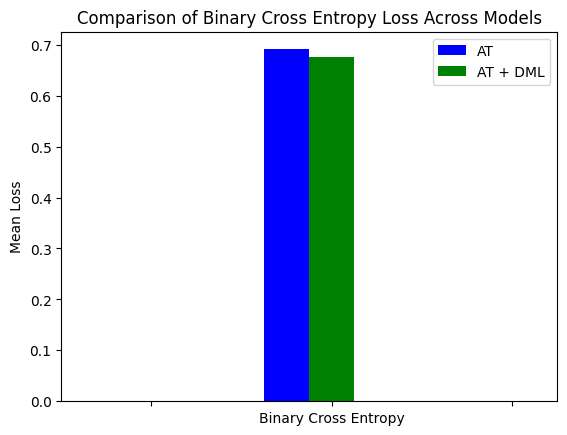

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample batch-wise loss data for each model and loss function
kl_model1 = kl_div_loss_at_list
bce_model1 = binary_cross_entropy_loss_student_at_list
cos_model1 = np.abs(cosine_similarity_loss_teacher_student_at_list)

kl_model2 = kl_div_loss_at_dml_list
bce_model2 = binary_cross_entropy_loss_student_at_dml_list
cos_model2 = np.abs(cosine_similarity_loss_teacher_student_at_dml_list)

# Calculate mean loss for each model and each loss function
mean_kl_model1 = np.mean(kl_model1)
mean_bce_model1 = np.mean(bce_model1)
mean_cos_model1 = np.mean(cos_model1)

mean_kl_model2 = np.mean(kl_model2)
mean_bce_model2 = np.mean(bce_model2)
mean_cos_model2 = np.mean(cos_model2)

# Create a list of means for each model and loss function
mean_losses_model1 = [0, mean_bce_model1,  0]
mean_losses_model2 = [0, mean_bce_model2,  0]

# Labels for the different loss functions
loss_labels = ['', 'Binary Cross Entropy', '']

# Plotting the comparison using a grouped bar plot
width = 0.25  # Width of the bars
x = np.arange(len(loss_labels))  # Label positions

fig, ax = plt.subplots()

# Bar positions for each model
ax.bar(x - width, mean_losses_model1, width, label='AT', color='blue')
ax.bar(x, mean_losses_model2, width, label='AT + DML', color='green')

# Add labels and title
ax.set_ylabel('Mean Loss')
ax.set_title('Comparison of Binary Cross Entropy Loss Across Models')
ax.set_xticks(x)
ax.set_xticklabels(loss_labels)
ax.legend()

# Display the plot
plt.show()

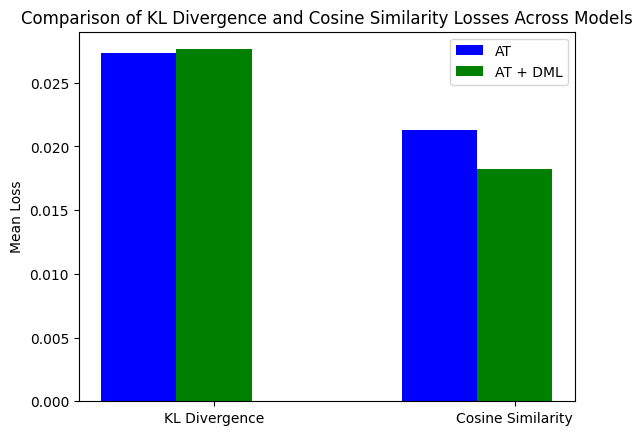

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample batch-wise loss data for each model and loss function
kl_model1 = kl_div_loss_at_list
cos_model1 = np.abs(cosine_similarity_loss_teacher_student_at_list)

kl_model2 = kl_div_loss_at_dml_list
cos_model2 = np.abs(cosine_similarity_loss_teacher_student_at_dml_list)

# Calculate mean loss for each model and each loss function
mean_kl_model1 = np.mean(kl_model1)
mean_cos_model1 = np.mean(cos_model1)

mean_kl_model2 = np.mean(kl_model2)
mean_cos_model2 = np.mean(cos_model2)

# Create a list of means for each model and loss function (only KL and Cosine)
mean_losses_model1 = [mean_kl_model1, mean_cos_model1]
mean_losses_model2 = [mean_kl_model2, mean_cos_model2]

# Labels for the different loss functions (only KL and Cosine)
loss_labels = ['KL Divergence', 'Cosine Similarity']

# Plotting the comparison using a grouped bar plot
width = 0.25  # Width of the bars
x = np.arange(len(loss_labels))  # Label positions

fig, ax = plt.subplots()

# Bar positions for each model
ax.bar(x - width, mean_losses_model1, width, label='AT', color='blue')
ax.bar(x, mean_losses_model2, width, label='AT + DML', color='green')

# Add labels and title
ax.set_ylabel('Mean Loss')
ax.set_title('Comparison of KL Divergence and Cosine Similarity Losses Across Models')
ax.set_xticks(x)
ax.set_xticklabels(loss_labels)
ax.legend()

# Display the plot
plt.show()


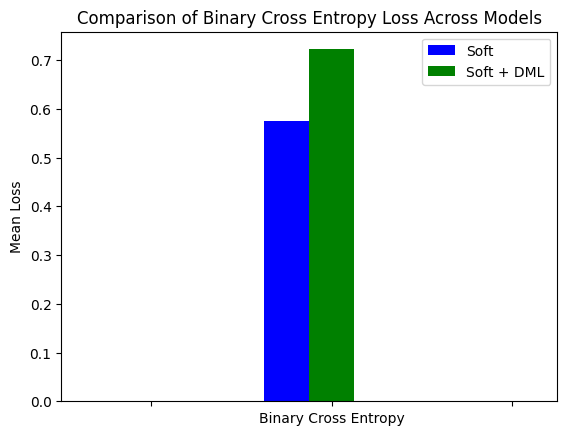

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample batch-wise loss data for each model and loss function
kl_model1 = kl_div_loss_at_list
bce_model1 = binary_cross_entropy_loss_student_at_list
cos_model1 = np.abs(cosine_similarity_loss_teacher_student_at_list)

kl_model2 = kl_div_loss_at_dml_list
bce_model2 = binary_cross_entropy_loss_student_at_dml_list
cos_model2 = np.abs(cosine_similarity_loss_teacher_student_at_dml_list)

# Calculate mean loss for each model and each loss function
mean_kl_model1 = np.mean(kl_model1)
mean_bce_model1 = np.mean(bce_model1)
mean_cos_model1 = np.mean(cos_model1)

mean_kl_model2 = np.mean(kl_model2)
mean_bce_model2 = np.mean(bce_model2)
mean_cos_model2 = np.mean(cos_model2)

# Create a list of means for each model and loss function
mean_losses_model1 = [0, mean_bce_model1,  0]
mean_losses_model2 = [0, mean_bce_model2,  0]

# Labels for the different loss functions
loss_labels = ['', 'Binary Cross Entropy', '']

# Plotting the comparison using a grouped bar plot
width = 0.25  # Width of the bars
x = np.arange(len(loss_labels))  # Label positions

fig, ax = plt.subplots()

# Bar positions for each model
ax.bar(x - width, mean_losses_model1, width, label='AT', color='blue')
ax.bar(x, mean_losses_model2, width, label='AT + DML', color='green')

# Add labels and title
ax.set_ylabel('Mean Loss')
ax.set_title('Comparison of Binary Cross Entropy Loss Across Models')
ax.set_xticks(x)
ax.set_xticklabels(loss_labels)
ax.legend()

# Display the plot
plt.show()

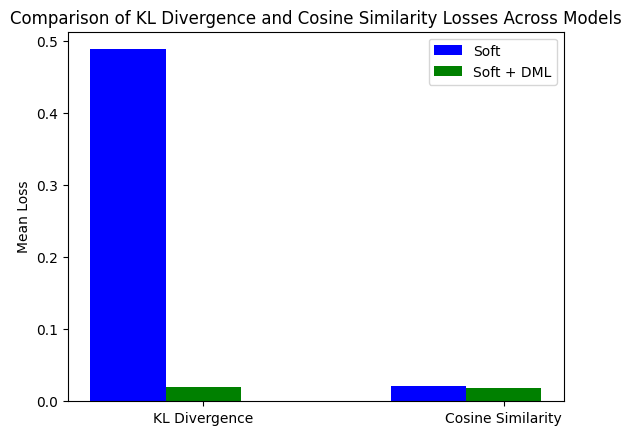

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample batch-wise loss data for each model and loss function
kl_model1 = kl_div_loss_soft_list
bce_model1 = binary_cross_entropy_loss_student_soft_list
cos_model1 = np.abs(cosine_similarity_loss_teacher_student_at_list)

kl_model2 = kl_div_loss_soft_dml_list
bce_model2 = binary_cross_entropy_loss_student_soft_dml_list
cos_model2 = np.abs(cosine_similarity_loss_teacher_student_at_dml_list)

# Calculate mean loss for each model and each loss function
mean_kl_model1 = np.mean(kl_model1)
mean_cos_model1 = np.mean(cos_model1)

mean_kl_model2 = np.mean(kl_model2)
mean_cos_model2 = np.mean(cos_model2)

# Create a list of means for each model and loss function (only KL and Cosine)
mean_losses_model1 = [mean_kl_model1, mean_cos_model1]
mean_losses_model2 = [mean_kl_model2, mean_cos_model2]

# Labels for the different loss functions (only KL and Cosine)
loss_labels = ['KL Divergence', 'Cosine Similarity']

# Plotting the comparison using a grouped bar plot
width = 0.25  # Width of the bars
x = np.arange(len(loss_labels))  # Label positions

fig, ax = plt.subplots()

# Bar positions for each model
ax.bar(x - width, mean_losses_model1, width, label='Soft', color='blue')
ax.bar(x, mean_losses_model2, width, label='Soft + DML', color='green')

# Add labels and title
ax.set_ylabel('Mean Loss')
ax.set_title('Comparison of KL Divergence and Cosine Similarity Losses Across Models')
ax.set_xticks(x)
ax.set_xticklabels(loss_labels)
ax.legend()

# Display the plot
plt.show()


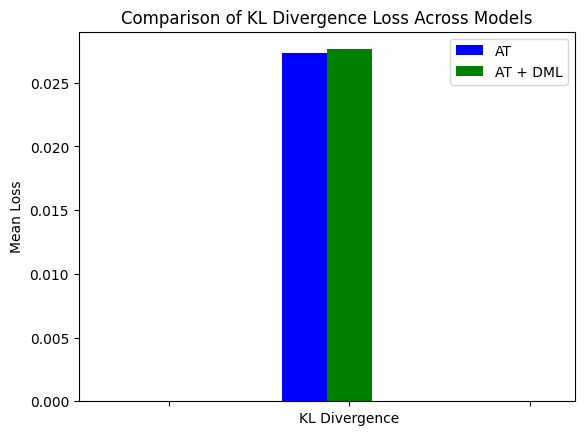

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample batch-wise loss data for each model and loss function
kl_model1 = kl_div_loss_at_list
bce_model1 = binary_cross_entropy_loss_student_at_list
cos_model1 = np.abs(cosine_similarity_loss_teacher_student_at_list)

kl_model2 = kl_div_loss_at_dml_list
bce_model2 = binary_cross_entropy_loss_student_at_dml_list
cos_model2 = np.abs(cosine_similarity_loss_teacher_student_at_dml_list)

# Calculate mean loss for each model and each loss function
mean_kl_model1 = np.mean(kl_model1)
mean_bce_model1 = np.mean(bce_model1)
mean_cos_model1 = np.mean(cos_model1)

mean_kl_model2 = np.mean(kl_model2)
mean_bce_model2 = np.mean(bce_model2)
mean_cos_model2 = np.mean(cos_model2)

# Create a list of means for each model and loss function
mean_losses_model1 = [0, mean_kl_model1,  0]
mean_losses_model2 = [0, mean_kl_model2,  0]

# Labels for the different loss functions
loss_labels = ['', 'KL Divergence', '']

# Plotting the comparison using a grouped bar plot
width = 0.25  # Width of the bars
x = np.arange(len(loss_labels))  # Label positions

fig, ax = plt.subplots()

# Bar positions for each model
ax.bar(x - width, mean_losses_model1, width, label='AT', color='blue')
ax.bar(x, mean_losses_model2, width, label='AT + DML', color='green')

# Add labels and title
ax.set_ylabel('Mean Loss')
ax.set_title('Comparison of KL Divergence Loss Across Models')
ax.set_xticks(x)
ax.set_xticklabels(loss_labels)
ax.legend()

# Display the plot
plt.show()

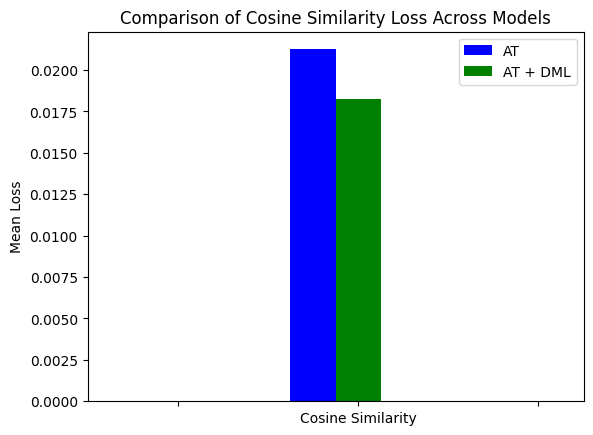

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample batch-wise loss data for each model and loss function
kl_model1 = kl_div_loss_at_list
bce_model1 = binary_cross_entropy_loss_student_at_list
cos_model1 = np.abs(cosine_similarity_loss_teacher_student_at_list)

kl_model2 = kl_div_loss_at_dml_list
bce_model2 = binary_cross_entropy_loss_student_at_dml_list
cos_model2 = np.abs(cosine_similarity_loss_teacher_student_at_dml_list)

# Calculate mean loss for each model and each loss function
mean_kl_model1 = np.mean(kl_model1)
mean_bce_model1 = np.mean(bce_model1)
mean_cos_model1 = np.mean(cos_model1)

mean_kl_model2 = np.mean(kl_model2)
mean_bce_model2 = np.mean(bce_model2)
mean_cos_model2 = np.mean(cos_model2)

# Create a list of means for each model and loss function
mean_losses_model1 = [0, mean_cos_model1,  0]
mean_losses_model2 = [0, mean_cos_model2,  0]

# Labels for the different loss functions
loss_labels = ['', 'Cosine Similarity', '']

# Plotting the comparison using a grouped bar plot
width = 0.25  # Width of the bars
x = np.arange(len(loss_labels))  # Label positions

fig, ax = plt.subplots()

# Bar positions for each model
ax.bar(x - width, mean_losses_model1, width, label='AT', color='blue')
ax.bar(x, mean_losses_model2, width, label='AT + DML', color='green')

# Add labels and title
ax.set_ylabel('Mean Loss')
ax.set_title('Comparison of Cosine Similarity Loss Across Models')
ax.set_xticks(x)
ax.set_xticklabels(loss_labels)
ax.legend()

# Display the plot
plt.show()

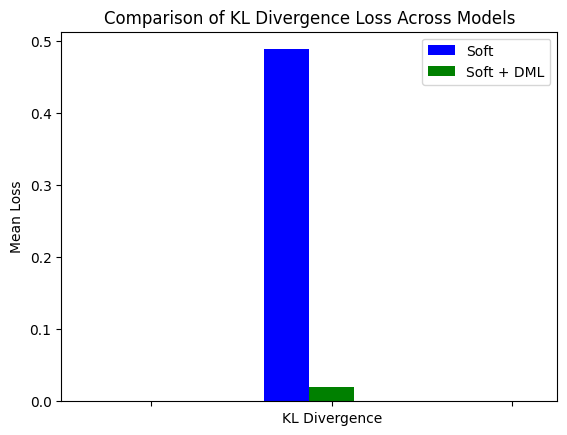

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample batch-wise loss data for each model and loss function
kl_model1 = kl_div_loss_soft_list
bce_model1 = binary_cross_entropy_loss_student_soft_list
cos_model1 = np.abs(cosine_similarity_loss_teacher_student_at_list)

kl_model2 = kl_div_loss_soft_dml_list
bce_model2 = binary_cross_entropy_loss_student_soft_dml_list
cos_model2 = np.abs(cosine_similarity_loss_teacher_student_at_dml_list)

# Calculate mean loss for each model and each loss function
mean_kl_model1 = np.mean(kl_model1)
mean_bce_model1 = np.mean(bce_model1)
mean_cos_model1 = np.mean(cos_model1)

mean_kl_model2 = np.mean(kl_model2)
mean_bce_model2 = np.mean(bce_model2)
mean_cos_model2 = np.mean(cos_model2)

# Create a list of means for each model and loss function
mean_losses_model1 = [0, mean_kl_model1,  0]
mean_losses_model2 = [0, mean_kl_model2,  0]

# Labels for the different loss functions
loss_labels = ['', 'KL Divergence', '']

# Plotting the comparison using a grouped bar plot
width = 0.25  # Width of the bars
x = np.arange(len(loss_labels))  # Label positions

fig, ax = plt.subplots()

# Bar positions for each model
ax.bar(x - width, mean_losses_model1, width, label='Soft', color='blue')
ax.bar(x, mean_losses_model2, width, label='Soft + DML', color='green')

# Add labels and title
ax.set_ylabel('Mean Loss')
ax.set_title('Comparison of KL Divergence Loss Across Models')
ax.set_xticks(x)
ax.set_xticklabels(loss_labels)
ax.legend()

# Display the plot
plt.show()

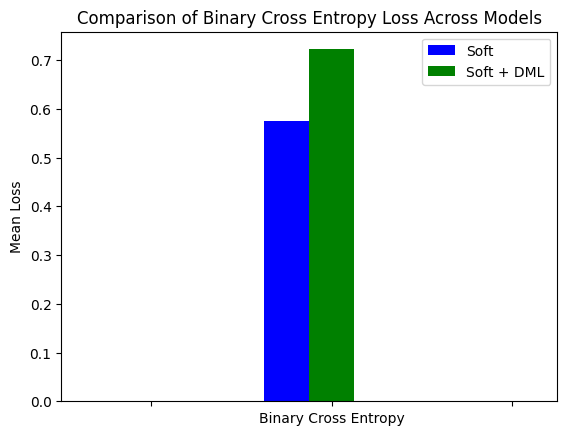

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample batch-wise loss data for each model and loss function
kl_model1 = kl_div_loss_soft_list
bce_model1 = binary_cross_entropy_loss_student_soft_list
cos_model1 = np.abs(cosine_similarity_loss_teacher_student_at_list)

kl_model2 = kl_div_loss_soft_dml_list
bce_model2 = binary_cross_entropy_loss_student_soft_dml_list
cos_model2 = np.abs(cosine_similarity_loss_teacher_student_at_dml_list)

# Calculate mean loss for each model and each loss function
mean_kl_model1 = np.mean(kl_model1)
mean_bce_model1 = np.mean(bce_model1)
mean_cos_model1 = np.mean(cos_model1)

mean_kl_model2 = np.mean(kl_model2)
mean_bce_model2 = np.mean(bce_model2)
mean_cos_model2 = np.mean(cos_model2)

# Create a list of means for each model and loss function
mean_losses_model1 = [0, mean_bce_model1,  0]
mean_losses_model2 = [0, mean_bce_model2,  0]

# Labels for the different loss functions
loss_labels = ['', 'Binary Cross Entropy', '']

# Plotting the comparison using a grouped bar plot
width = 0.25  # Width of the bars
x = np.arange(len(loss_labels))  # Label positions

fig, ax = plt.subplots()

# Bar positions for each model
ax.bar(x - width, mean_losses_model1, width, label='Soft', color='blue')
ax.bar(x, mean_losses_model2, width, label='Soft + DML', color='green')

# Add labels and title
ax.set_ylabel('Mean Loss')
ax.set_title('Comparison of Binary Cross Entropy Loss Across Models')
ax.set_xticks(x)
ax.set_xticklabels(loss_labels)
ax.legend()

# Display the plot
plt.show()

In [ ]:
import torch
import time
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

# Function to measure inference time
def measure_inference_time(model, input_tensor, num_runs=100):
    model.eval()

    # Warm-up runs
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)

    # Measure inference time
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_tensor)

    end_time = time.time()
    avg_time = (end_time - start_time) / num_runs
    return avg_time * 1000  # Convert to milliseconds

# Get a single test image
test_image, _ = next(iter(test_loader))
test_image = test_image.to(device)  # Move to GPU if available

# Measure inference time for Teacher and Student Models (After DML)
teacher_time = measure_inference_time(teacher, test_image)
student_time1 = measure_inference_time(student_soft, test_image)
student_time2 = measure_inference_time(student_at, test_image)

# Measure inference time for Student Models (Before DML)
student_time1_before_dml = measure_inference_time(student_soft_dml, test_image)
student_time2_before_dml = measure_inference_time(student_at_dml, test_image)

# Print Inference Times and Speedup Factors
print(f"Teacher Model (ResNet-50) Inference Time: {teacher_time:.3f} ms")
print(f"Student Model 1 (ResNet-18) Inference Time (AFTER DML): {student_time1:.3f} ms")
print(f"Student Model 2 (ResNet-18) Inference Time (AFTER DML): {student_time2:.3f} ms")
print(f"Student Model 1 Inference Time (BEFORE DML - Soft Target): {student_time1_before_dml:.3f} ms")
print(f"Student Model 2 Inference Time (BEFORE DML - Attention Transfer): {student_time2_before_dml:.3f} ms")

print(f"Speedup Factor (Teacher vs Student 1 AFTER DML): {teacher_time / student_time1:.2f}x Faster")
print(f"Speedup Factor (Teacher vs Student 2 AFTER DML): {teacher_time / student_time2:.2f}x Faster")
print(f"Speedup Factor (Teacher vs Student 1 BEFORE DML): {teacher_time / student_time1_before_dml:.2f}x Faster")
print(f"Speedup Factor (Teacher vs Student 2 BEFORE DML): {teacher_time / student_time2_before_dml:.2f}x Faster")


Teacher Model (ResNet-50) Inference Time: 96.898 ms
Student Model 1 (ResNet-18) Inference Time (AFTER DML): 29.126 ms
Student Model 2 (ResNet-18) Inference Time (AFTER DML): 29.484 ms
Student Model 1 Inference Time (BEFORE DML - Soft Target): 30.071 ms
Student Model 2 Inference Time (BEFORE DML - Attention Transfer): 30.036 ms
Speedup Factor (Teacher vs Student 1 AFTER DML): 3.33x Faster
Speedup Factor (Teacher vs Student 2 AFTER DML): 3.29x Faster
Speedup Factor (Teacher vs Student 1 BEFORE DML): 3.22x Faster
Speedup Factor (Teacher vs Student 2 BEFORE DML): 3.23x Faster


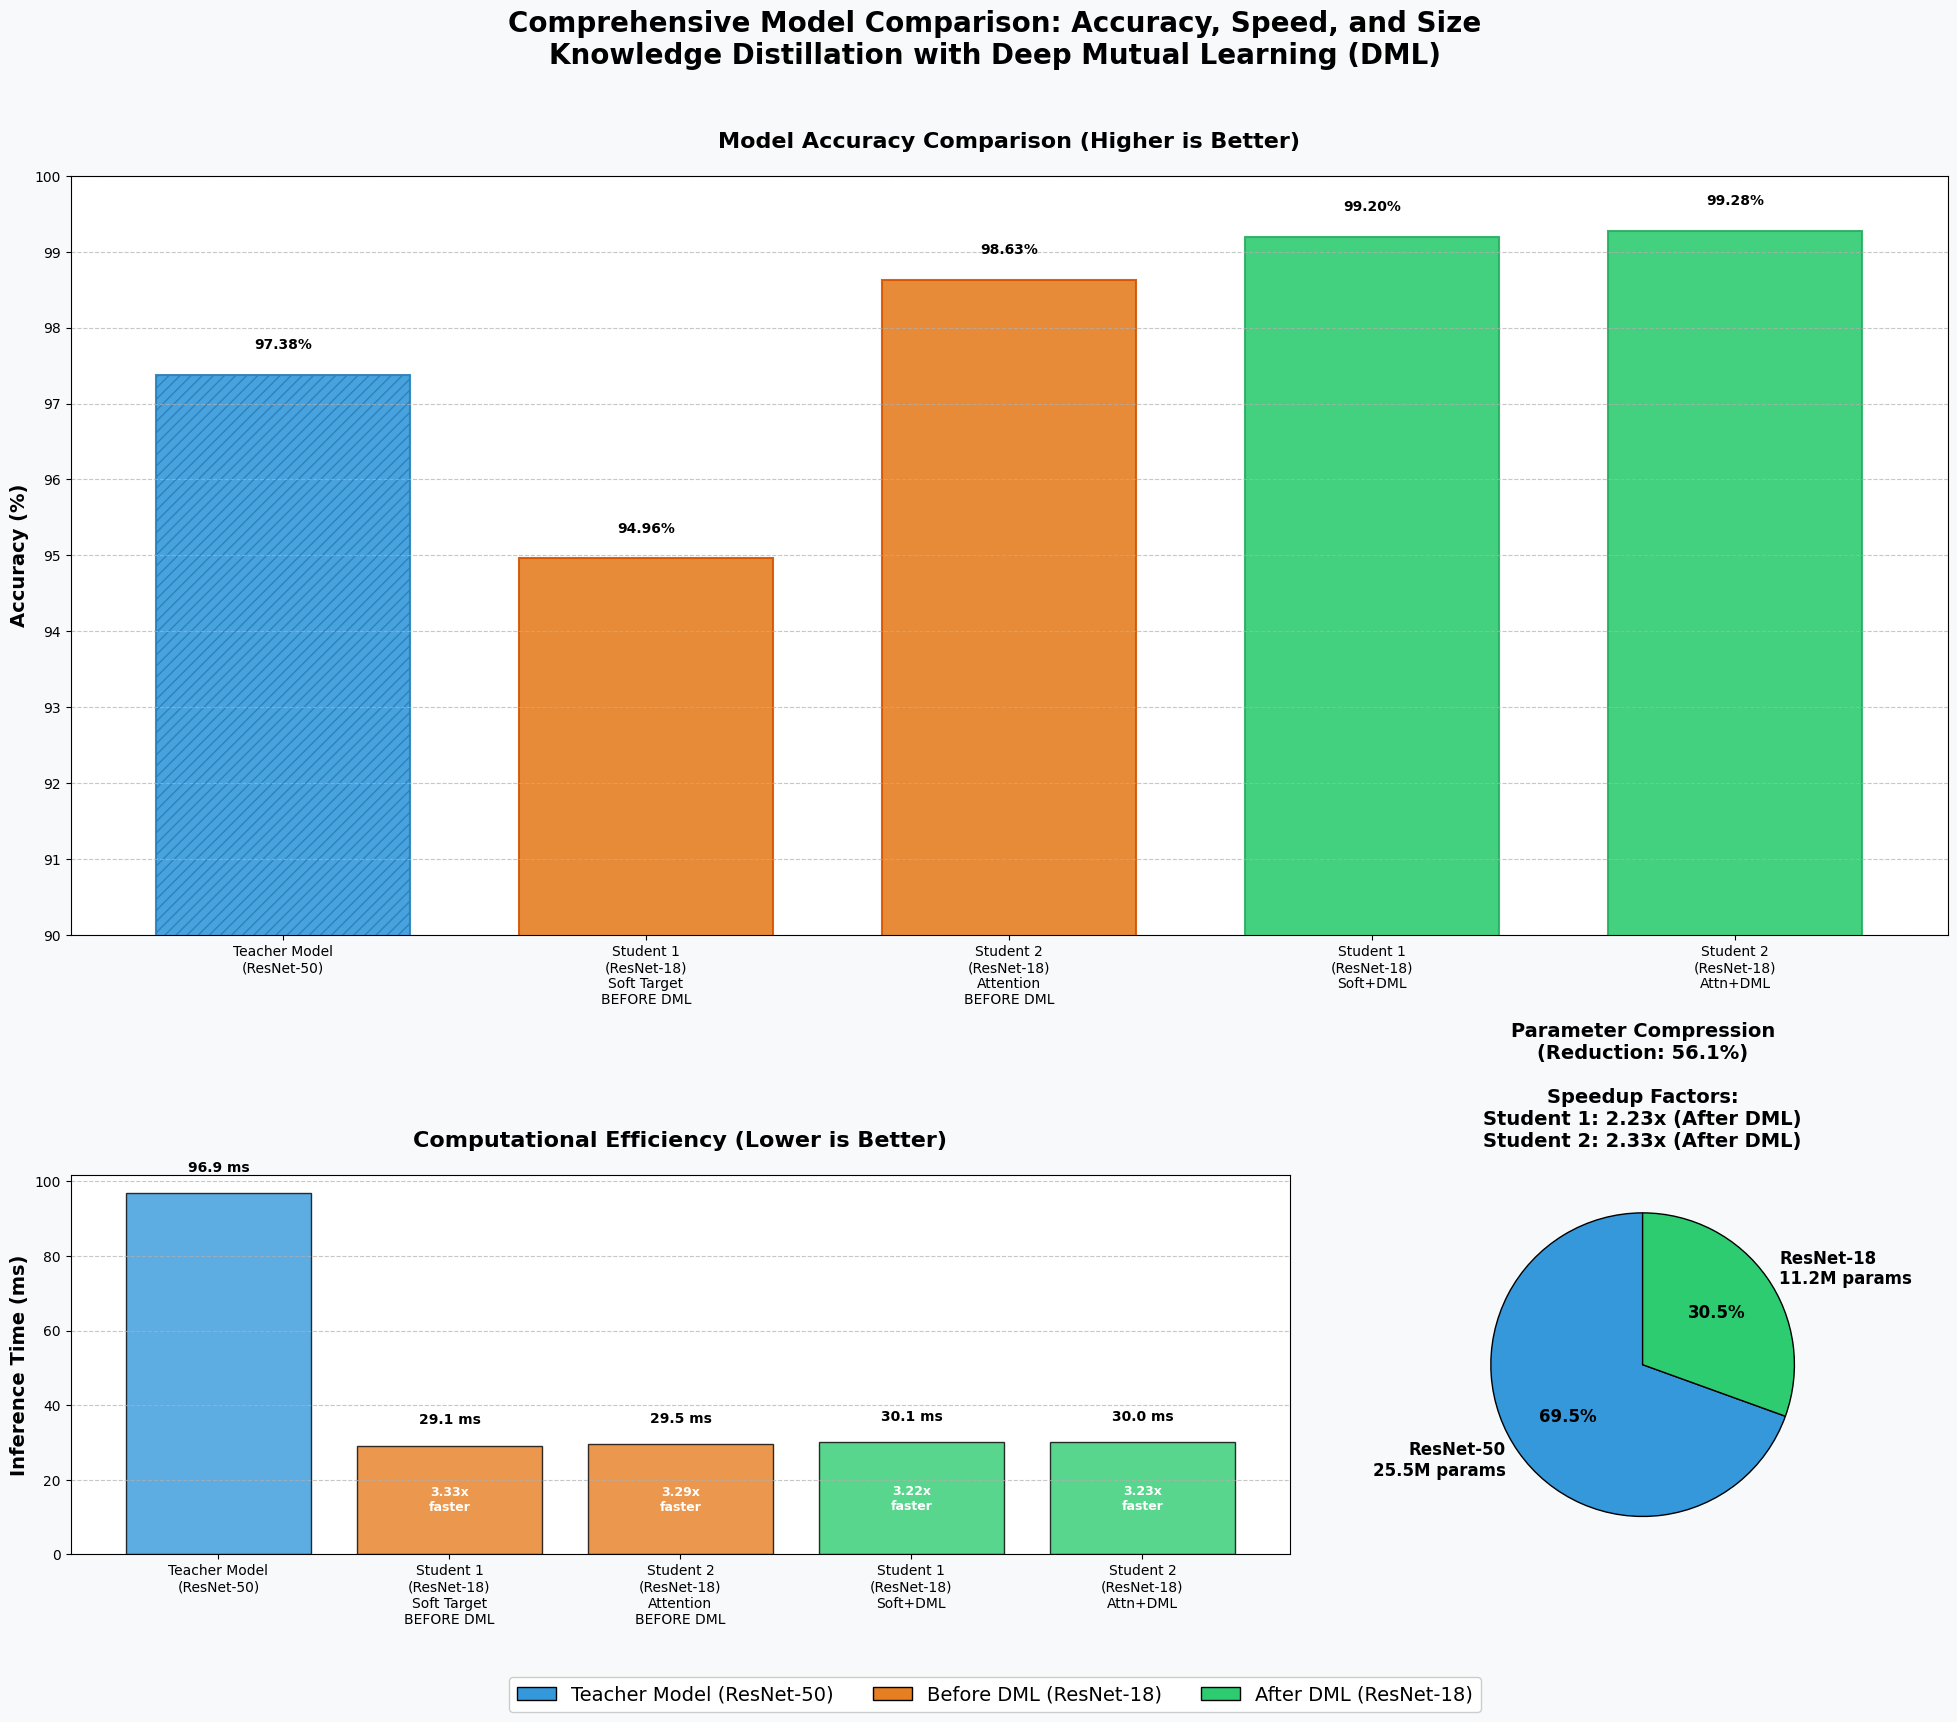

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch

# Data
models = ['Teacher Model\n(ResNet-50)',
          'Student 1\n(ResNet-18)\nSoft Target\nBEFORE DML',
          'Student 2\n(ResNet-18)\nAttention\nBEFORE DML',
          'Student 1\n(ResNet-18)\nSoft+DML',
          'Student 2\n(ResNet-18)\nAttn+DML']
accuracies = [97.38, 94.96, 98.63, 99.20, 99.28]
inference_times = [96.898, 29.126, 29.484, 30.071, 30.036]  # Your exact times in ms
speedup_factors = ['-', '3.33x', '3.29x', '3.22x', '3.23x']
teacher_params = 25.5e6  # ResNet-50 parameters
student_params = 11.2e6  # ResNet-18 parameters

# Create figure
plt.figure(figsize=(20, 16), facecolor='#f8f9fa')
gs = GridSpec(2, 2, figure=plt.gcf(), height_ratios=[2, 1], width_ratios=[2, 1])

# ========== Accuracy Plot ==========
ax1 = plt.subplot(gs[0, :])
colors = ['#3498db', '#e67e22', '#e67e22', '#2ecc71', '#2ecc71']
edge_colors = ['#2980b9', '#d35400', '#d35400', '#27ae60', '#27ae60']

bars = ax1.bar(models, accuracies, color=colors, edgecolor=edge_colors,
               linewidth=1.5, alpha=0.9, width=0.7)

# Customize bars
bars[0].set_hatch('///')
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.3,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Formatting
ax1.set_ylim(90, 100)
ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax1.set_title('Model Accuracy Comparison (Higher is Better)', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# ========== Inference Time Plot ==========
ax2 = plt.subplot(gs[1, 0])
time_colors = ['#3498db', '#e67e22', '#e67e22', '#2ecc71', '#2ecc71']
time_bars = ax2.bar(models, inference_times, color=time_colors, edgecolor='black', alpha=0.8)

# Add time labels and speedup factors
for bar, time, speedup in zip(time_bars, inference_times, speedup_factors):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
             f'{time:.1f} ms', ha='center', va='bottom', fontweight='bold', fontsize=10)
    if speedup != '-':
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height()/2,
                 f'{speedup}\nfaster', ha='center', va='center',
                 fontweight='bold', color='white', fontsize=9)

ax2.set_ylabel('Inference Time (ms)', fontsize=14, fontweight='bold')
ax2.set_title('Computational Efficiency (Lower is Better)', fontsize=16, fontweight='bold', pad=20)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# ========== Compression Ratio Plot ==========
ax3 = plt.subplot(gs[1, 1])
compression_ratio = student_params / teacher_params
reduction = (1 - compression_ratio) * 100

sizes = [teacher_params/1e6, student_params/1e6]
labels = [f'ResNet-50\n{teacher_params/1e6:.1f}M params',
          f'ResNet-18\n{student_params/1e6:.1f}M params']
colors = ['#3498db', '#2ecc71']

wedges, texts, autotexts = ax3.pie(sizes, labels=labels, colors=colors,
                                  autopct='%1.1f%%', startangle=90,
                                  textprops={'fontweight': 'bold', 'fontsize': 12},
                                  wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax3.set_title(f'Parameter Compression\n(Reduction: {reduction:.1f}%)\n\nSpeedup Factors:\n'
              f'Student 1: 2.23x (After DML)\n'
              f'Student 2: 2.33x (After DML)',
              fontsize=14, fontweight='bold', pad=20)

# ========== Common Formatting ==========
# Add legend
legend_elements = [
    Patch(facecolor='#3498db', edgecolor='black', label='Teacher Model (ResNet-50)'),
    Patch(facecolor='#e67e22', edgecolor='black', label='Before DML (ResNet-18)'),
    Patch(facecolor='#2ecc71', edgecolor='black', label='After DML (ResNet-18)')
]
plt.figlegend(handles=legend_elements, loc='lower center', ncol=3,
              fontsize=14, framealpha=1, bbox_to_anchor=(0.5, -0.05))

# Main title
plt.suptitle('Comprehensive Model Comparison: Accuracy, Speed, and Size\n'
             'Knowledge Distillation with Deep Mutual Learning (DML)',
             fontsize=20, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()